In [0]:
#import findspark
#findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pandas as pd
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import pyspark.ml.classification as cl
import pyspark.ml.evaluation as ev

In [0]:
import pyspark.sql.types as typ
labels = [
    ('_c0',typ.IntegerType()), #it seems we has to add it here, otherwise the positions of columns would be incorrect
    ('birth_place',typ.IntegerType()),
    ('mothers_age',typ.IntegerType()),
    ('fathers_age',typ.IntegerType()),
    ('prental_care',typ.IntegerType()),
    ('cigarettes_before_pregnancy',typ.IntegerType()),
    ('cigarettes_1_trimester',typ.IntegerType()),
    ('cigarettes_2_trimester',typ.IntegerType()),
    ('cigarettes_3_trimester',typ.IntegerType()),
    ('mothers_height',typ.IntegerType()),
    ('bmi',typ.DecimalType()),
    ('prepregnancy_weight',typ.DecimalType()), #note: it has be Decimal, otherwise the value will become null
    ('delivery_weight',typ.IntegerType()),
    ('weight_gain',typ.IntegerType()),
    ('prepregnancy_diabetes',typ.StringType()),
    ('gestational_diabetes',typ.StringType()),
    ('prepregnancy_hypertension',typ.StringType()),
    ('gestational_hypertension',typ.StringType()),
    ('hypertension_eclampsia',typ.StringType()),
    ('previous_preterm_birth',typ.StringType()),
    ('infant_sex',typ.StringType()),
    ('infant_live',typ.StringType()),
]
schema = typ.StructType([
    typ.StructField(e[0],e[1],False) for e in labels
])
births = spark.read.csv('/FileStore/tables/nat18.csv', header = True, schema = schema)
#births = spark.read.csv('nat18.csv', header = True, schema = schema)

In [0]:
#check if our dataset contains any missing values
bool(births.head(1)) #if the result is False，then the dataset has missing values，otherwise no.

Out[3]: True

In [0]:
#filter out unknown any cases
births = births.filter((births.infant_live != 'U'))
births = births.filter((births.prepregnancy_diabetes != 'U'))
births = births.filter((births.gestational_diabetes != 'U'))
births = births.filter((births.prepregnancy_hypertension != 'U'))
births = births.filter((births.gestational_hypertension!= 'U'))
births = births.filter((births.hypertension_eclampsia!= 'U'))
births = births.filter((births.previous_preterm_birth!= 'U'))
births = births.filter((births.fathers_age!= 99))
births = births.filter((births.cigarettes_before_pregnancy!= 99))
births = births.filter((births.cigarettes_1_trimester!= 99))
births = births.filter((births.cigarettes_2_trimester!= 99))
births = births.filter((births.cigarettes_3_trimester!= 99))
births = births.filter((births.mothers_height!= 99))
births = births.filter((births.bmi!= 100))
births = births.filter((births.prepregnancy_weight!= 999))
births = births.filter((births.delivery_weight!= 999))
births = births.filter((births.weight_gain!= 99))

In [0]:
births.groupby('infant_live').count().show() #The result show our contains imbalaced classes

+-----------+-------+
infant_live| count|
+-----------+-------+
 Y|3224846|
 N| 2213|
+-----------+-------+

In [0]:
#Basical dataset statistical check
#if the dataset contains duplicate rows:
print('Count of rows: {0}'.format(births.count()))
print('Count of distinct rows: {0}'.format(births.distinct().count()))
#the results show our dataset contains no same rows

Count of rows: 3227059
Count of distinct rows: 3227059

In [0]:
#For numerical data, apply the describe() to get statistical summay.
numerical = ['mothers_age', 'fathers_age', 'cigarettes_before_pregnancy','cigarettes_1_trimester'
            ,'cigarettes_2_trimester','cigarettes_3_trimester','mothers_height','bmi'
            ,'prepregnancy_weight','delivery_weight','weight_gain']
desc = births.describe(numerical)
desc.toPandas()

,summary,mothers_age,fathers_age,cigarettes_before_pregnancy,cigarettes_1_trimester,cigarettes_2_trimester,cigarettes_3_trimester,mothers_height,bmi,prepregnancy_weight,delivery_weight,weight_gain
0,count,3227059,3227059,3227059,3227059,3227059,3227059,3227059,3227059,3227059,3227059,3227059
1,mean,29.369372236454307,31.787807412259895,0.9047463960218887,0.536430229506185,0.4000633394059421,0.35471523762038437,64.14300017446226,27.0720,158.3142,187.8532930448436,29.630798817127296
2,stddev,5.6560968024642735,6.794544600008508,4.268990604512939,3.0017986187169283,2.466927699787358,2.315872797492891,2.822443566919063,6.599992026459632,40.89583149538059,40.43973722280019,14.838047763424326
3,min,12,11,0,0,0,0,36,13,75,100,0
4,max,50,95,98,98,98,98,78,70,375,400,98


In [0]:
#correlation:
import pyspark.mllib.stat as st
numeric_rdd = births.select(numerical).rdd.map(lambda row: [e for e in row])
corrs = st.Statistics.corr(numeric_rdd)
for i, f in enumerate(corrs>0.5):
  correlated = [
    (numerical[j], corrs[i][j])
    for j, e in enumerate(f)
    if e == 1.0 and j !=i]
  if len(correlated) > 0:
    for e in correlated:
      print('{0}-to-{1}:{2:.2f}'.format(numerical[i],e[0],e[1]))

mothers_age-to-fathers_age:0.74
fathers_age-to-mothers_age:0.74
cigarettes_before_pregnancy-to-cigarettes_1_trimester:0.79
cigarettes_before_pregnancy-to-cigarettes_2_trimester:0.70
cigarettes_before_pregnancy-to-cigarettes_3_trimester:0.65
cigarettes_1_trimester-to-cigarettes_before_pregnancy:0.79
cigarettes_1_trimester-to-cigarettes_2_trimester:0.88
cigarettes_1_trimester-to-cigarettes_3_trimester:0.82
cigarettes_2_trimester-to-cigarettes_before_pregnancy:0.70
cigarettes_2_trimester-to-cigarettes_1_trimester:0.88
cigarettes_2_trimester-to-cigarettes_3_trimester:0.93
cigarettes_3_trimester-to-cigarettes_before_pregnancy:0.65
cigarettes_3_trimester-to-cigarettes_1_trimester:0.82
cigarettes_3_trimester-to-cigarettes_2_trimester:0.93
bmi-to-prepregnancy_weight:0.94
bmi-to-delivery_weight:0.84
prepregnancy_weight-to-bmi:0.94
prepregnancy_weight-to-delivery_weight:0.93
delivery_weight-to-bmi:0.84
delivery_weight-to-prepregnancy_weight:0.93

In [0]:
#based on the above collinear test, wed decide to drop bmi, delivery_weight, and cigarettes_3_trimester since they are close to 1
births = births.drop('bmi','cigarettes_3_trimester','_c0')
births = births.drop('delivery_weight')

In [0]:
#feature engineering - covert target data to dummy variable
import pyspark.sql.functions as fn
#1.
categ = births.select('infant_live').distinct().rdd.flatMap(lambda x:x).collect()
exprs = [fn.when(fn.col('infant_live') == Y,1).otherwise(0)\
            .alias(str(Y)) for Y in categ]
births = births.select(exprs+births.columns)
#drop useless columns and rename target column
births = births.drop('N')
births = births.drop('infant_live')
births = births.withColumnRenamed('Y','infant_live_encoded')

In [0]:
#categorical variables' frequencies:
categorical_cols = [e for e in births.columns
                   if e not in numerical]
categorical_rdd = births.select(categorical_cols).rdd.map(lambda row: [e for e in row])
for i, col in enumerate(categorical_cols):
  agg = categorical_rdd.groupBy(lambda row:row[i]).map(lambda row: (row[0], len(row[1])))
  print(col,sorted(agg.collect(), key = lambda e1:e1[1], reverse = True))

infant_live_encoded [(1, 3224846), (0, 2213)]
birth_place [(1, 3172735), (2, 54187), (3, 137)]
prental_care [(1, 3218713), (0, 8346)]
prepregnancy_diabetes [('N', 3197686), ('Y', 29373)]
gestational_diabetes [('N', 3004412), ('Y', 222647)]
prepregnancy_hypertension [('N', 3164911), ('Y', 62148)]
gestational_hypertension [('N', 2999409), ('Y', 227650)]
hypertension_eclampsia [('N', 3219517), ('Y', 7542)]
previous_preterm_birth [('N', 3121429), ('Y', 105630)]
infant_sex [('M', 1650185), ('F', 1576874)]

In [0]:
#check if there has any significant differences within our features:
import pyspark.mllib.linalg as ln
for cat in categorical_cols[1:]:
  agg = births.groupBy('infant_live_encoded').pivot(cat).count()
  agg_rdd = agg.rdd.map(lambda row:(row[1:])).flatMap(lambda row:[0 if e == None else e for e in row]).collect()
  row_length = len(agg.collect()[0])-1
  agg = ln.Matrices.dense(row_length,2,agg_rdd)
  test = st.Statistics.chiSqTest(agg)
  print(cat, round(test.pValue,2))
  #since prental_care and gestational_diabetes' p-values are greater than 0.05, so they are independent to our target.
  #in other words, the posibilities of prental_care and gestational_diabetes happening has no relationship
  #with the posibility of whether the newborns are alive or not.

birth_place 0.0
prental_care 0.25
prepregnancy_diabetes 0.0
gestational_diabetes 0.95
prepregnancy_hypertension 0.0
gestational_hypertension 0.01
hypertension_eclampsia 0.0
previous_preterm_birth 0.0
infant_sex 0.0

In [0]:
#drop indepent variables:
births = births.drop('prental_care','gestational_diabetes')

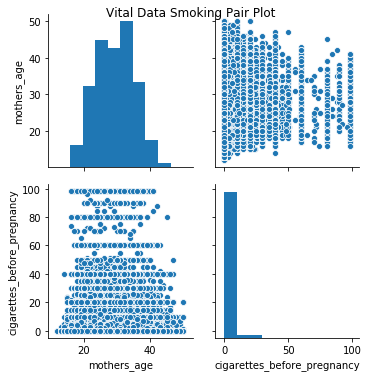

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.pairplot(births.toPandas()[['mothers_age','cigarettes_before_pregnancy']])
ax.fig.suptitle("Vital Data Smoking Pair Plot", y=1.01)

In [0]:
#check the ratio of the classes
import pyspark.sql.functions as fn
births_v1 = births
major_df = births_v1.filter(fn.col("infant_live_encoded")==1)
minor_df = births_v1.filter(fn.col("infant_live_encoded")==0)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 1457

In [0]:
#Since the ratio and the dataset size are fairly large, we decided to perform undersampling:
sampled_majority_df = major_df.sample(False, 1/ratio)
combined_df = sampled_majority_df.unionAll(minor_df)
combined_df.groupby('infant_live_encoded').count().show()

+-------------------+-----+
infant_live_encoded|count|
+-------------------+-----+
 1| 2183|
 0| 2213|
+-------------------+-----+

In [0]:
##feature engineerings: convert categorical ordinal data into integer before vectorizing and standarizing
import pyspark.ml.feature as ft
from pyspark.ml import Pipeline
#1.feature: sex
stringIndexer1 = ft.StringIndexer(inputCol='infant_sex', handleInvalid='skip',outputCol = "indexed_sex")
encoder1 = ft.OneHotEncoder(inputCol='indexed_sex',outputCol = "infant_sex_encoded",dropLast=False)
sex_pipe = Pipeline(stages = [stringIndexer1, encoder1])

#2. feature: prepregnancy_diabetes
stringIndexer2 = ft.StringIndexer(inputCol='prepregnancy_diabetes', handleInvalid='skip',outputCol =                  "indexed_prepregnancy_diabetes")
encoder2 = ft.OneHotEncoder(inputCol='indexed_prepregnancy_diabetes',outputCol = "prepregnancy_diabetes_encoded",dropLast=False)
pd_pipe = Pipeline(stages = [stringIndexer2, encoder2])

#3. feature: prepregnancy_hypertension
stringIndexer4 = ft.StringIndexer(inputCol='prepregnancy_hypertension', handleInvalid='skip',outputCol = "indexed_prepregnancy_hypertension")
encoder4 = ft.OneHotEncoder(inputCol='indexed_prepregnancy_hypertension',outputCol = "prepregnancy_hypertension_encoded",dropLast=False)
ph_pipe = Pipeline(stages = [stringIndexer4, encoder4])

#4. feature: gestational_hypertension
stringIndexer5 = ft.StringIndexer(inputCol='gestational_hypertension', handleInvalid='skip',outputCol = "indexed_gestational_hypertension")
encoder5 = ft.OneHotEncoder(inputCol='indexed_gestational_hypertension',outputCol = "gestational_hypertension_encoded",dropLast=False)
gh_pipe = Pipeline(stages = [stringIndexer5, encoder5])

#5. feature: hypertension_eclampsia
stringIndexer6 = ft.StringIndexer(inputCol='hypertension_eclampsia', handleInvalid='skip',outputCol = "indexed_hypertension_eclampsia")
encoder6 = ft.OneHotEncoder(inputCol='indexed_hypertension_eclampsia',outputCol = "hypertension_eclampsia_encoded",dropLast=False)
he_pipe = Pipeline(stages = [stringIndexer6, encoder6])

#6. feature: previous_preterm_birth
stringIndexer7 = ft.StringIndexer(inputCol='previous_preterm_birth', handleInvalid='skip',outputCol = "indexed_previous_preterm_birth")
encoder7 = ft.OneHotEncoder(inputCol='indexed_previous_preterm_birth',outputCol = "previous_preterm_birth_encoded",dropLast=False)
ppb_pipe = Pipeline(stages = [stringIndexer7, encoder7])

In [0]:
births.printSchema()

root
-- infant_live_encoded: integer (nullable = false)
-- birth_place: integer (nullable = true)
-- mothers_age: integer (nullable = true)
-- fathers_age: integer (nullable = true)
-- cigarettes_before_pregnancy: integer (nullable = true)
-- cigarettes_1_trimester: integer (nullable = true)
-- cigarettes_2_trimester: integer (nullable = true)
-- mothers_height: integer (nullable = true)
-- prepregnancy_weight: decimal(10,0) (nullable = true)
-- weight_gain: integer (nullable = true)
-- prepregnancy_diabetes: string (nullable = true)
-- prepregnancy_hypertension: string (nullable = true)
-- gestational_hypertension: string (nullable = true)
-- hypertension_eclampsia: string (nullable = true)
-- previous_preterm_birth: string (nullable = true)
-- infant_sex: string (nullable = true)

In [0]:
#numerical data
numerical_pipe = Pipeline(stages = [ft.VectorAssembler(inputCols=['birth_place', 'mothers_age', 'fathers_age','cigarettes_before_pregnancy', 'cigarettes_1_trimester'
                                    ,'cigarettes_2_trimester','mothers_height'
                                    ,'prepregnancy_weight','weight_gain'], outputCol = 'num_features'),
                                   ft.StandardScaler(inputCol="num_features", outputCol="scaledFeatures",withMean = True, withStd = True)])

In [0]:
#final feature engineering pipeline
all_features = Pipeline(stages = [numerical_pipe,
                                 sex_pipe,
                                 pd_pipe,
                                 ph_pipe,
                                 gh_pipe,
                                 he_pipe,
                                 ppb_pipe,
                                 ft.VectorAssembler(inputCols = ['scaledFeatures',
                                                                'infant_sex_encoded',
                                                                'prepregnancy_diabetes_encoded',
                                                                'prepregnancy_hypertension_encoded',
                                                                'gestational_hypertension_encoded',
                                                                'hypertension_eclampsia_encoded',
                                                                'previous_preterm_birth_encoded'],
                                                   outputCol = 'features')])

In [0]:
#build a logistic regression model
logistic = cl.LogisticRegression(featuresCol = 'features',labelCol ='infant_live_encoded')

In [0]:
#build a simple pipeline
pipeline = Pipeline(stages = [all_features, logistic])

In [0]:
#Binary Classification evaluation
evaluator = ev.BinaryClassificationEvaluator(
                rawPredictionCol = 'probability',
                labelCol = 'infant_live_encoded')
#test the undersampling dataset performance
train, val = combined_df.randomSplit([0.7,0.3],seed = 666)
model = pipeline.fit(train)
test_model = model.transform(val)
#print out the results:
print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderPR'}))

0.6198728121488725
0.5943868299184369

In [0]:
#the undersampling dataset had poor performances, so we would like to try the original dataset
#split dataset into training and testing sets
train2, val2 = births.randomSplit([0.7,0.3],seed = 666)
#fit the training set with default settings of LR
test_model2 = pipeline.fit(train2)

In [0]:
#evaluate perfromance on training data:
lr_summary = test_model2.stages[-1].summary
#accuracy:
print('The training model Accuracy: ',lr_summary.accuracy)
#areaunderROC:
print('The training model ROC: ',lr_summary.areaUnderROC)
#weightedRecall
print('The training model Recall: ',lr_summary.weightedRecall)
#weightedPrecision
print('The training model Precision: ',lr_summary.weightedPrecision)

The training model Accuracy: 0.9993125084940394
The training model ROC: 0.6161336524371346
The training model Recall: 0.9993125084940394
The training model Precision: 0.9986254896326496

In [0]:
#evaluate perfromance on testing data:
lr_model = test_model2.transform(val2)
#rawPredictionCol can be either rawPredictionCol or probability
print('The testing model ROC:', evaluator.evaluate(lr_model, {evaluator.metricName: 'areaUnderROC'}))
print('The testing model PR:',evaluator.evaluate(lr_model, {evaluator.metricName: 'areaUnderPR'}))
#it seems we gave up a little bit of  ROC score but gained lots of PR score, so we would like to do our project with the original dataset
true_pos1 = lr_model.filter(lr_model['infant_live_encoded']==1).filter(lr_model['prediction']==1).count()
actual_pos1 = lr_model.filter(lr_model['infant_live_encoded']==1).count()
pred_pos1 = lr_model.filter(lr_model['prediction']==1).count()
#The testing set recall:
print('The testing model Recall: ',float(true_pos1)/(actual_pos1))
#The testing set precision:
print('The testing model Precision: ',float(true_pos1)/(pred_pos1))

The testing model ROC: 0.608303033028061
The testing model PR: 0.9995169344609497
The testing model Recall: 1.0
The testing model Precision: 0.9993182677389834

In [0]:
#Define the mse function
mse = fn.mean((fn.col('infant_live_encoded') - fn.col('prediction'))**2).alias('mse')
#lr model's testing mse
print('The mse score of lr model:')
lr_model.select(mse).show()

The mse score of lr model:
+------------------+
 mse|
+------------------+
6.8173226101669E-4|
+------------------+

In [0]:
#check the most important features
lrmodel = test_model2.stages[-1]
pd.DataFrame(pd.DataFrame(list(zip(births.columns[1:], lrmodel.coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending=False))

,column,weight
8,weight_gain,0.330292
11,gestational_hypertension,0.207647
10,prepregnancy_hypertension,0.112673
13,previous_preterm_birth,0.087538
4,cigarettes_1_trimester,0.049070
6,mothers_height,0.000323
7,prepregnancy_weight,-0.008751
3,cigarettes_before_pregnancy,-0.013760
2,fathers_age,-0.027171
1,mothers_age,-0.030633


In [0]:
#we want to check other classification models, like random forest
#second model: random forest

In [0]:
#first we converted our target type to Double
births = births.withColumn('infant_live_encoded', fn.col('infant_live_encoded').cast(typ.DoubleType()))

In [0]:
#build rf model and check the performance
train3, val3 = births.randomSplit([0.7,0.3],seed = 666)
rf = cl.RandomForestClassifier(numTrees = 5,
                              maxDepth = 5,
                              labelCol = 'infant_live_encoded')
rf_pipe = Pipeline(stages = [all_features, rf])
test_model3 = rf_pipe.fit(train3)

In [0]:
#evaluate perfromance on testing data:
rf_model = test_model3.transform(val3)
print('The testing model ROC:',evaluator.evaluate(rf_model, {evaluator.metricName: 'areaUnderROC'}))
print('The testing model PR:',evaluator.evaluate(rf_model, {evaluator.metricName: 'areaUnderPR'}))
true_pos2 = rf_model.filter(rf_model['infant_live_encoded']==1).filter(rf_model['prediction']==1).count()
actual_pos2 = rf_model.filter(rf_model['infant_live_encoded']==1).count()
pred_pos2 = rf_model.filter(rf_model['prediction']==1).count()
#The testing set recall:
print('The testing model Recall: ',float(true_pos2)/(actual_pos2))
#The testing set precision:
print('The testing model Precision: ',float(true_pos2)/(pred_pos2))

The testing model ROC: 0.5068257437783321
The testing model PR: 0.9996607262554006
The testing model Recall: 1.0
The testing model Precision: 0.9993182677389834

In [0]:
#rf model's testing mse
print('The mse score of rf model:')
rf_model.select(mse).show()

The mse score of rf model:
+------------------+
 mse|
+------------------+
6.8173226101669E-4|
+------------------+

In [0]:
#rf_model.featureImportances
rfmodel = test_model3.stages[-1]
pd.DataFrame(list(zip(births.columns[1:], rfmodel.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

,column,weight
13,previous_preterm_birth,0.898903
12,hypertension_eclampsia,0.048978
7,prepregnancy_weight,0.032887
0,birth_place,0.019232
1,mothers_age,0.000000
2,fathers_age,0.000000
3,cigarettes_before_pregnancy,0.000000
4,cigarettes_1_trimester,0.000000
5,cigarettes_2_trimester,0.000000
6,mothers_height,0.000000


In [0]:
#general compare of the lr and rf models:
bce = ev.BinaryClassificationEvaluator(
                rawPredictionCol = 'probability',
                labelCol = 'infant_live_encoded')
print("lr model overall performance: ", bce.evaluate(lr_model))
print("rf model overall performance: ", bce.evaluate(rf_model))

lr model overall performance: 0.6083062059660883
rf model overall performance: 0.5068257437783321

In [0]:
#to make our model selection, we build dics to make our results easy to understand:
lr_dic = {'Model':'Logisitc Regression',
         'ROC score':evaluator.evaluate(lr_model, {evaluator.metricName: 'areaUnderROC'}),
         'PR score':evaluator.evaluate(lr_model, {evaluator.metricName: 'areaUnderPR'}),
         'MSE score':lr_model.select(mse),
         'Overall performance':bce.evaluate(lr_model)}
rf_dic = {'Model':'Random Forest',
         'ROC score':evaluator.evaluate(rf_model, {evaluator.metricName: 'areaUnderROC'}),
         'PR score':evaluator.evaluate(rf_model, {evaluator.metricName: 'areaUnderPR'}),
         'MSE score':rf_model.select(mse),
         'Overall performance':bce.evaluate(rf_model)}
print('the lr model summary:', lr_dic)
print('the rf model summary:', rf_dic)

the lr model summary: {'Model': 'Logisitc Regression', 'ROC score': 0.608320631401512, 'PR score': 0.9995169019374079, 'MSE score': DataFrame[mse: double], 'Overall performance': 0.6083291001391145}
the rf model summary: {'Model': 'Random Forest', 'ROC score': 0.5068257437783321, 'PR score': 0.9996607262554006, 'MSE score': DataFrame[mse: double], 'Overall performance': 0.5068257437783321}

In [0]:
#logistic regression model hyperparameters tuning and cross-validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [0]:
#use ParamgridBuilder and CrossValidator for hyperparameter tuning
train4, val4 = births.randomSplit([0.7,0.3],seed = 666)
#our logistic regression model has better performance.gi
lr = cl.LogisticRegression(featuresCol = 'features',labelCol = 'infant_live_encoded')
paramGrid = (ParamGridBuilder()
            .addGrid(lr.maxIter, [2, 5, 10]) 
            .addGrid(lr.regParam, [0.1, 0.3, 0.5])
            .addGrid(lr.elasticNetParam, [0.01, 0.2, 0.3])
            .build())

lr_evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol = 'probability',
                labelCol = 'infant_live_encoded')

cv = CrossValidator(estimator=lr, estimatorParamMaps= paramGrid
                    ,evaluator=lr_evaluator, numFolds=3)
#tuning
pipeline = Pipeline(stages = [all_features])
feature_transformer = pipeline.fit(train4)
cv_model = cv.fit(feature_transformer.transform(train4)) #returns the best model
data_train = feature_transformer.transform(val4)
grid_model = cv_model.transform(data_train)

/databricks/spark/python/pyspark/ml/util.py:762: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [0]:
#get the best model hyperparameters:
results = [
  (
  [
    {key.name:paramValue}
    for key, paramValue in zip(params.keys(),params.values())
  ],metric)
  for params, metric in zip(cv_model.getEstimatorParamMaps(),
                            cv_model.avgMetrics)
]
sorted(results, key = lambda e1:e1[1],
      reverse = True)[0]

Out[57]: ([{'maxIter': 2}, {'regParam': 0.1}, {'elasticNetParam': 0.01}], 0.5)

In [0]:
#best model performance
print(evaluator.evaluate(grid_model, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(grid_model, {evaluator.metricName: 'areaUnderPR'}))

0.5
0.9993182677389834

In [0]:
#for selecting best model, another way is train-validation split
#using ChiSqSelector to select top 7 features to limit the model complexity
from pyspark.ml.tuning import TrainValidationSplit
selector = ft.ChiSqSelector(
                numTopFeatures = 7,
                featuresCol = 'features',
                outputCol = 'selectedFeatures',
                labelCol = 'infant_live_encoded')
lr_2 = cl.LogisticRegression(labelCol = 'infant_live_encoded',
                                featuresCol = 'selectedFeatures')
pipeline2 = Pipeline(stages = [all_features, selector])
data_transformer2 = pipeline2.fit(train4)
tvs = TrainValidationSplit(estimator = lr_2, 
                           estimatorParamMaps= paramGrid
                        ,evaluator = lr_evaluator)
tvsModel = tvs.fit(data_transformer2.transform(train4))
data_train2 = data_transformer2.transform(val4)
tvs_model = tvsModel.transform(data_train2)

In [0]:
#best model performance
print(evaluator.evaluate(tvs_model, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(tvs_model, {evaluator.metricName: 'areaUnderPR'}))

0.6026551798479532
0.9995047319573913

In [0]:
#general performance
print("lr model overall performance: ", bce.evaluate(tvs_model))

lr model overall performance: 0.6026749973986919

In [0]:
#get the top 7 features select by the ChiSqSelector:
pd.DataFrame(pd.DataFrame(list(zip(births.columns[1:], tvsModel.bestModel.coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight'))

,column,weight
4,cigarettes_1_trimester,-0.935414
6,mothers_height,-0.381214
0,birth_place,-0.058323
3,cigarettes_before_pregnancy,-0.011814
1,mothers_age,-0.010252
5,cigarettes_2_trimester,0.111693
2,fathers_age,0.329133


In [0]:
#roc curve
FPR = tvsModel.bestModel.summary.roc.select('FPR').collect()
TPR = tvsModel.bestModel.summary.roc.select('TPR').collect()

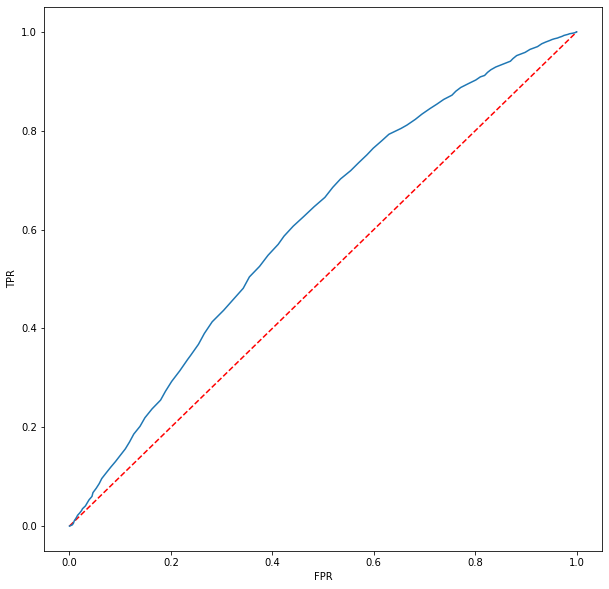

In [0]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'r--') # "random guess" line
plt.plot(FPR,TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [0]:
#PR curve
recall = tvsModel.bestModel.summary.pr.select('recall').collect()
precision = tvsModel.bestModel.summary.pr.select('precision').collect()

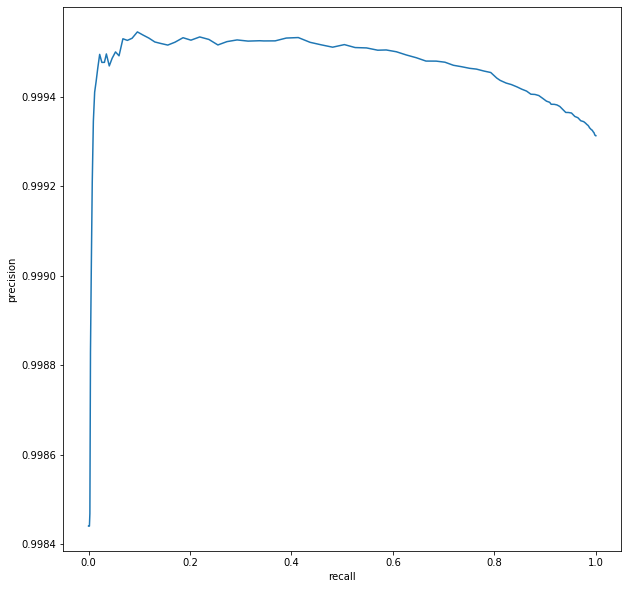

In [0]:
plt.figure(figsize=(10,10))
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()